Author: François Mercier

Goals: 
- Analyze differences between monolingual and bilingual corpora
- Generate first dataset

# Imports

Additional requirements for this notebook (not part of main requirements)
```
pip install --no-index matplotlib 
pip install --no-index scikit-learn
pip install --no-index seaborn
pip install fastprogress
````

In [12]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

In [94]:
import sklearn
import matplotlib.pyplot as plt 
import seaborn as sns
from pathlib import Path
import pandas as pd
import numpy as np
import json
import pickle

from fastprogress import progress_bar

In [14]:
from __future__ import absolute_import, division, print_function, unicode_literals

import tensorflow as tf
tf.__version__

'2.0.0'

In [15]:
import spacy

spacy.__version__

'2.2.2'

In [16]:
import sys
sys.path.append("..") # Require to have the utilities packages in path
from tools import tokenizer

In [17]:
pd.set_option('display.max_columns', 999)
pd.set_option('display.max_colwidth', 999)
pd.set_option('display.max_rows', 999)

In [18]:
# python -m spacy download en_core_web_sm
tokenizer_en = spacy.load("en_core_web_sm") 

# Add back the sentencizer because the tokenizer will run without other parts
tokenizer_en.add_pipe(tokenizer_en.create_pipe('sentencizer'))

# python -m spacy download fr_core_news_sm
tokenizer_fr = spacy.load("fr_core_news_sm") 

# Add back the sentencizer because the tokenizer will run without other parts
tokenizer_fr.add_pipe(tokenizer_fr.create_pipe('sentencizer'))


In [19]:
tokenizer_en.pipeline

[('tagger', <spacy.pipeline.pipes.Tagger at 0x2b183f19d150>),
 ('parser', <spacy.pipeline.pipes.DependencyParser at 0x2b1852161fa0>),
 ('ner', <spacy.pipeline.pipes.EntityRecognizer at 0x2b1852161f30>),
 ('sentencizer', <spacy.pipeline.pipes.Sentencizer at 0x2b18414c1910>)]

In [20]:
data_path = Path(r"/project/cq-training-1/project2/data/")
files = list(data_path.glob("*"))
files

[PosixPath('/project/cq-training-1/project2/data/unaligned.en'),
 PosixPath('/project/cq-training-1/project2/data/unaligned.fr'),
 PosixPath('/project/cq-training-1/project2/data/train.lang2'),
 PosixPath('/project/cq-training-1/project2/data/train.lang1')]

## English corpora

# Quick analysis of unaligned_en

In [22]:
with open(data_path / "unaligned.en", 'r') as f:
    unaligned_en = [line.rstrip() for line in f] # Remove the \n
    unaligned_en = pd.DataFrame(unaligned_en, columns=["text"])
    f.close()

unaligned_en.describe()

,text
count,474000
unique,466177
top,I can't tell you how happy I am that you've come to visit us.
freq,15


In [212]:
dup_ratio = 1 - (unaligned_en.text.unique().shape[0] / unaligned_en.text.shape[0])
print("Duplication ratio", dup_ratio)

Duplication ratio 0.016504219409282705


Text(0.5, 1.0, 'Histogram per characters')

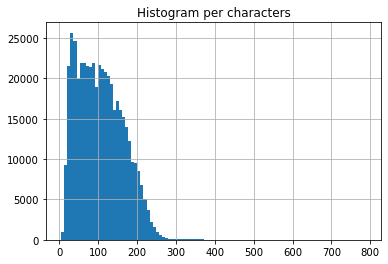

In [213]:
ax = unaligned_en.text.str.len().hist(bins=100)
ax.set_title("Histogram per characters")

In [214]:
unaligned_en.text.str.len().describe(percentiles=[.25, .5, .75, .9, .99])

count    474000.000000
mean        106.462382
std          58.117838
min           5.000000
25%          57.000000
50%         101.000000
75%         148.000000
90%         187.000000
99%         240.000000
max         788.000000
Name: text, dtype: float64

In [215]:
unaligned_en[unaligned_en.text.str.len() > 240].sample(n = 5)

,text
165702,There are many types of nuclear installations in Europe today and it will certainly be necessary to continue the efforts undertaken by industrial circles and the authorities responsible for safety to approximate the specifications and to define our joint demands.
300738,"And that's that when you strip away all your feelings about politics and the line at the DMV and all those other things that we're really mad about, government is, at its core, in the words of Tim O'Reilly, ""What we do together that we can't do alone."""
124837,"sent her back to the hospital that she had just come from, no one read the chart, put her on Tylenol, which she is allergic to, broke out, got bedsores, basically, had heart problems, and died from the fall and the complications and the errors that were there."
198456,"Subject: Møllergårdens Vivaldi - a Shetland pony The Committee on Petitions decided on 15 May 1997 to examine a case concerning the Shetland pony, Møllergårdens Vivaldi, from Denmark, which the Swedish authorities refused to register as a stallion in Sweden."
105399,"You can compare how that building, in terms of its emission in tons of carbon dioxide per year -- at the time that we took that project, over 7,000 tons -- what it would have been with natural gas and finally, with the vegetable oil, 450 tons."


In [216]:
unaligned_en[unaligned_en.text.str.len() > 400].sample(n = 5)

,text
401249,"Think of it in the following terms. Think of it as beginning to program stuff for specific purposes. Think of the cell as a hardware. Think of the genes as a software. And in the measure that you begin to think of life as code that is interchangeable, that can become energy, that can become food, that can become fiber, that can become human beings, that can become a whole series of things, then you've got to shift your approach as to how you're going to structure and deal and think about energy in a very different way."
392111,"And so, when you fly down -- Thank you. When you fly down to the ground, and you see this kind of panoramic imagery, the first thing that you might notice is that it's not just a picture, there's just as much three-dimensional understanding of this environment as there is of the three-dimensional city from above, so if I click on something to get a closer view of it, then, the fact that that transition looks as it does, is a function of all of that geometry, all of that 3D understanding behind this model."
215410,"We looked at the historical attempts that had been out there and realized that, despite the fact that we have a lot of modern innovations to draw on today that weren't available previously -- we have modern composite materials, we have aircraft engines that get good fuel economy and have better power-to-rate ratios than have ever been available, we have glass cockpit avionics that bring the information you need to fly directly to you in the cockpit -- but without fundamentally addressing the problem from a different perspective, we realized that we were going to be getting the same result that people had been getting for the last hundred years, which isn't where we want to be right now."
97432,"And in this paper, they show something much more striking, and that was that they did what they call a radiation -- and I'm not going to go into the details of it, actually it's quite complicated, but it isn't as complicated as they might make you think it is by the words they use in those papers. If you really get down to it, they say, the sun puts out a certain amount of energy -- we know how much that is -- it falls on the earth, the earth gives back a certain amount."
121086,"Imagine what you'll tell your children when they ask you, ""So, in 2012, Mom and Dad, what was it like when you'd had the hottest decade on record for the third decade in a row, when every scientific body in the world was saying you've got a major problem, when the oceans were acidifying, when oil and food prices were spiking, when they were rioting in the streets of London and occupying Wall Street?"


- Presence of duplicated lines in unaligned_en (1.6%)
- Few sentences with more than 400 characters contains actually several sentences (not split)
- Most sentences with less than 240 characters
- No lowercase and not tokenized (presence of coma and so on)

# Quick analysis of train.lang1

In [23]:
with open(data_path / "train.lang1", 'r') as f:
    train_lang1_en = [line.rstrip() for line in f] # Remove the \n
    train_lang1_en = pd.DataFrame(train_lang1_en, columns=["text"])
    f.close()

train_lang1_en.describe()

,text
count,11000
unique,10995
top,i ca n't tell you how happy i am that you 've come to visit us
freq,3


In [218]:
dup_ratio = 1 - (train_lang1_en.text.unique().shape[0] / train_lang1_en.text.shape[0])
print("Duplication ratio", dup_ratio)

Duplication ratio 0.00045454545454548523


Text(0.5, 1.0, 'Histogram per characters')

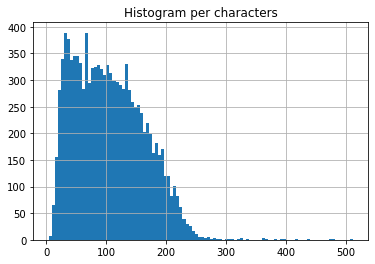

In [219]:
ax = train_lang1_en.text.str.len().hist(bins=100)
ax.set_title("Histogram per characters")

In [220]:
train_lang1_en.text.str.len().describe(percentiles=[.25, .5, .75, .9, .99])

count    11000.000000
mean       105.172182
std         58.009205
min          4.000000
25%         56.000000
50%        100.000000
75%        147.000000
90%        186.000000
99%        236.010000
max        512.000000
Name: text, dtype: float64

In [221]:
train_lang1_en[train_lang1_en.text.str.len() > 240].sample(n = 5)

,text
4312,instead of going out and guessing about our ancestry digging things up out of the ground possible ancestors and saying it on the basis of morphology -- which we still do n't completely understand we do n't know the genetic causes underlying this morphological variation -- what we need to do is turn the problem on its head
4902,now these are things about general culture but i 'm also very much interested in political culture and whether liberty and democracy is appreciated or whether there 's an authoritarian political culture in which the state is supposed to impose things on the citizens
10180,that is military science and technology that they need can create the advanced materials - industrial cluster that transforms its civilian economy and gets the country off oil which would be a huge contribution to eliminating conflict over oil and advancing national and global security
2575,if we do encounter actual cases of fraud or irregularities in carrying out our normal auditing tasks we naturally work together with the national criminal investigation authorities - as well as uclaf - so that matters take their proper course
9017,i would welcome it if the commissioner would confirm very clearly today that the new investment services directive – isd-2 – will not prevent people from using the execution - only services and direct offer products that they find so valuable


In [222]:
train_lang1_en[train_lang1_en.text.str.len() > 400].sample(n = 5)

,text
4710,second problem that people sometimes talk about with military use of non - lethal weapons and it 's actually the reason why in the chemical weapons convention it 's very clear that you ca n't use riot control agents as a weapon of warfare the problem with that is that it 's seen that sometimes non - lethal weapons might actually be used not as an alternative to lethal force but as a lethal force multiplier -- that you use non - lethal weapons first so that your lethal weapons will actually be more effective
9627,but it appeared to me that all these years that i 'd been working on exploitation -- exploitation by landlords by moneylenders by traders -- gave me an insight that probably i was also an exploiter because there was no line in my income tax return which showed this income accrued because of the brilliance of the people -- those people who have shared their knowledge and good faith and trust with me -- and nothing ever went back to them
4829,now in the decade of darfur and iraq a statement like that might seem somewhere between hallucinatory and obscene but i 'm going to try to convince you that that is the correct picture the decline of violence is a fractal phenomenon you can see it over millennia over centuries over decades and over years although there seems to have been a tipping point at the onset of the age of reason in the sixteenth century one sees it all over the world although not homogeneously
10759,and those simple words brought back many thoughts that i had had before about the fusion of our souls into one higher - level entity about the fact that at the core of both our souls lay our identical hopes and dreams for our children about the notion that those hopes were not separate or distinct hopes but were just one hope one clear thing that defined us both that welded us into a unit -- the kind of unit i had but dimly imagined before being married and having children
9931,-- it was printed in monterey i checked and the story began former vice president al gore announced in nigeria yesterday my wife tipper and i have opened a low - cost family restaurant named shoney 's and we are running it ourselves before i could get back to u.s soil david letterman and jay leno had already started in on -- one of them had me in a big white chef 's hat tipper was saying one more burger with fries


- Almost no duplicated lines in train_lang1_en
- Some sentences with more than 400 characters contains actually several sentences (not split)
- Distribution is cleaner compared to monolingual corpus
- Max sequence is 512 characters
- Most sequences with less than 236 characters
- lowercase and already preprocessed (ex: "it", "'s")

## French corpora

# Quick analysis of unaligned.fr

In [116]:
with open(data_path / "unaligned.fr", 'r') as f:
    unaligned_fr = [line.rstrip() for line in f] # Remove the \n
    unaligned_fr = pd.DataFrame(unaligned_fr, columns=["text"])
    f.close()

unaligned_fr.describe()

,text
count,474000
unique,471825
top,Le débat est clos.
freq,9


In [224]:
dup_ratio = 1 - (unaligned_fr.text.unique().shape[0] / unaligned_fr.text.shape[0])
print("Duplication ratio", dup_ratio)

Duplication ratio 0.004588607594936733


Text(0.5, 1.0, 'Histogram per characters')

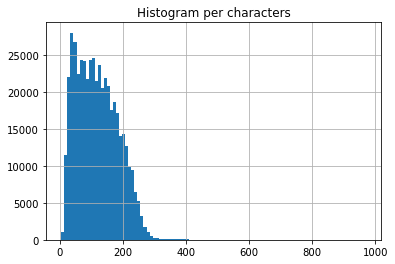

In [225]:
ax = unaligned_fr.text.str.len().hist(bins=100)
ax.set_title("Histogram per characters")

In [226]:
unaligned_fr.text.str.len().describe(percentiles=[.25, .5, .75, .9, .99])

count    474000.000000
mean        119.912194
std          65.138216
min           5.000000
25%          65.000000
50%         114.000000
75%         167.000000
90%         211.000000
99%         266.000000
max         969.000000
Name: text, dtype: float64

In [227]:
unaligned_fr[unaligned_fr.text.str.len() > 240].sample(n = 5)

,text
287730,"Les drogues synthétiques, en particulier, représentent un problème dont l'ampleur va sans cesse croissant, car leurs composants chimiques, les fameux précurseurs, peuvent être modifiés très aisément et rapidement, et échapper de la sorte aux législations."
417652,"Toutefois, parallèlement, bien que les relations entre l'UE et Andorre se soient développées, elles restent fragmentées, de vastes pans de l'acquis relatif au marché intérieur n'ayant pas été repris dans la législation andorrane et n'étant donc pas applicables."
176831,"En effet, comme le nom l'indique, la recommandation vise les États membres, lesquels peuvent la suivre mais n'y sont pas contraints, de sorte que déterminer des prescriptions légales dans le cadre d'une telle recommandation n'est pas possible."
376952,"Un certain nombre d’États membres, par exemple, sont très préoccupés par le fait que des enfants restent sans la surveillance appropriée d’un adulte à certains moments, lorsque leurs parents et les personnes qui s’en occupent sont au travail."
44631,"Les Etats-Unis n’ont jamais été favorables à l’inclusion de points concernant les droits de l’homme dans les accords commerciaux ; au mieux, et sous la pression, les présidents américains ont consenti à inclure des clauses sociales et environnementales."


In [228]:
unaligned_fr[unaligned_fr.text.str.len() > 300].sample(n = 5)

,text
107712,"Une fois que l'animal sait que clic, nourriture, clic, nourriture, clic, nourriture -- que donc le clic équivaut à la nourriture -- nous l'amenons dans une cage avec un trou, et l'animal apprend en fait à coller son nez au trou sous lequel une odeur cible est placée, et de faire ça pendant cinq secondes -- cinq secondes, ce qui est long pour un rat."
68532,"Une femme a pris cette énergie et a dit ""Je veux apporter cette vague, cette énergie, sur les campus des universités"", et elle a pris la pièce et dit ""Utilisons cette pièce et montons des représentations une fois par an afin de collecter des fonds pour mettre fin aux violences faites aux femmes dans les communautés locales à travers le monde."""
412890,"Donc si un radiologue regarde la radio d'un patient avec une pneumonie suspectée, disons, ce qui se passe c'est que, s'ils mettent en évidence une pneumonie sur la radio, ils arrêtent littéralement de la regarder -- ainsi ils passent à côté de la tumeur située à 7,6 cm plus bas sur les poumons du patient."
110638,"Nous avons maintenant une vision et une façon plus démocratiques de faire de la musique, un échange de bons procédés En tant que chef-d'orchestre, je dois venir à la répétition avec une idée ferme de l'architecture extérieure de cette musique, dans laquelle il y a alors une liberté personnelle immense de briller pour les membres de l'orchestre."
226004,"Et puis nous sommes passés à une autre elle n'avait pas de super visuels, mais elle avait des super informations -- et nous avons passé une heure à parler du processus d'apprentissage, parce que la question n'était pas si oui ou non c'était parfait, ou si oui ou non c'était ce que je pouvais créer; c'était de leur demander de créer par eux-mêmes."


- Almost no duplicated lines in unaligned_fr
- Some sentences with more than 400 characters contains actually several sentences (not split)
- Max sequence is 969 characters
- Most sequences with less than 266 characters
- No preprocessing (punctuation and case)

# Quick analysis of train.lang2

In [120]:
with open(data_path / "train.lang2", 'r') as f:
    train_lang2_fr = [line.rstrip() for line in f] # Remove the \n
    train_lang2_fr = pd.DataFrame(train_lang2_fr, columns=["text"])
    f.close()

train_lang2_fr.describe()

,text
count,11000
unique,10999
top,J' ai posé la main sur son épaule .
freq,2


In [230]:
dup_ratio = 1 - (train_lang2_fr.text.unique().shape[0] / train_lang2_fr.text.shape[0])
print("Duplication ratio", dup_ratio)

Duplication ratio 9.090909090914145e-05


Text(0.5, 1.0, 'Histogram per characters')

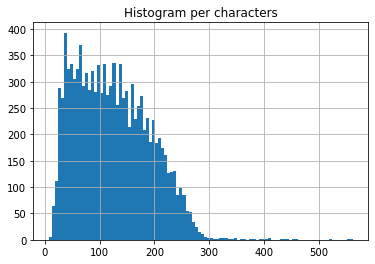

In [231]:
ax = train_lang2_fr.text.str.len().hist(bins=100)
ax.set_title("Histogram per characters")

In [232]:
train_lang2_fr.text.str.len().describe(percentiles=[.25, .5, .75, .9, .99])

count    11000.000000
mean       123.898636
std         66.795198
min          7.000000
25%         68.000000
50%        117.000000
75%        173.000000
90%        216.000000
99%        272.000000
max        562.000000
Name: text, dtype: float64

In [233]:
train_lang2_fr[train_lang2_fr.text.str.len() > 240].sample(n = 5)

,text
1962,"Il se trouve , Monsieur le Président , que ces pays , bien qu' ils aient accepté dans leurs accords de coopération avec l' Union européenne la clause démocratique , sont ceux qui sont le moins bien traités , en règle générale , par le budget communautaire ."
7974,"C' est donc dans cette perspective qu' il faut apprécier notre proposition : protéger le bien-être des animaux , garantir un niveau élevé de protection de la santé et éviter un contentieux juridique qui serait certainement dommageable pour tout le monde ."
10491,"Il y a six mois , dans cette même Assemblée , le Premier ministre britannique déclarait que nous devions laisser de côté notre égoïsme national si nous voulions faire de l’ Europe un continent politiquement crédible et économiquement compétitif , basé sur la solidarité ."
4710,"Le second problème de l' utilisation des armes non létales par l' armée , dont on parle parfois , c' est d' ailleurs la raison pour laquelle , dans la convention sur les armes chimiques , il est très clair que vous ne pouvez pas utiliser des agents anti-émeute comme une arme de guerre , le problème est que l' on voit quelquefois des armes non létales utilisées , non pas comme une alternative à la force létale , mais comme un amplificateur de cette force -- vous utilisez d' abord les armes non létales afin que les armes létales soient plus efficaces ."
8347,"La politique commerciale de la Communauté doit donc être cohérente avec les objectifs de sa politique relative aux pays en développement , dont l’ objectif suprême doit résider dans l’ élimination de la pauvreté et la promotion du développement durable ."


In [234]:
train_lang2_fr[train_lang2_fr.text.str.len() > 500]#.sample(n = 5)

,text
4710,"Le second problème de l' utilisation des armes non létales par l' armée , dont on parle parfois , c' est d' ailleurs la raison pour laquelle , dans la convention sur les armes chimiques , il est très clair que vous ne pouvez pas utiliser des agents anti-émeute comme une arme de guerre , le problème est que l' on voit quelquefois des armes non létales utilisées , non pas comme une alternative à la force létale , mais comme un amplificateur de cette force -- vous utilisez d' abord les armes non létales afin que les armes létales soient plus efficaces ."
9931,"même à Monterey , j' ai vérifié . Et l' article disait : "" L' ancien vice-président Al Gore a annoncé hier au Nigéria , "" Ma femme Tipper et moi avons ouvert un restaurant familial à bas prix , le Shoney' s , et nous nous en occupons nous - mêmes . "" --Rires-- Avant même d' avoir posé le pied aux USA , David Letterman et Jay Leno s' étaient déjà jetés sur l' histoire -- l' un d' eux me montrait sur une photo avec une toque de chef , et avec Tipper disant "" Un autre hamburger avec des frites , s' il vous plaît ! """
10759,"Et ces simples mots ont ravivé de nombreuses pensées que j' avais eu auparavant , sur la fusion de nos âmes en une entité de niveau plus élevé , sur le fait qu' au coeur de nos deux âmes se trouvent des espoirs et des rêves identiques pour nos enfants , sur la notion que ces espoirs n' étaient pas des espoirs séparés ou distincts , mais n' étaient qu' un espoir , une chose claire qui nous définissait tous les deux , qui nous soudaient en une seule unité -- le genre d' unité que je n' avais que vaguement imaginé avant d' être marié et d' avoir des enfants ."


- Almost no duplicated lines in train_lang1_en
- Some sentences with more than 400 characters contains actually several sentences (not split)
- Max sequence 562
- Most sequences with less than 272 characters
- Presence of case and punctuation
- But tokenize (ex: "n'", "étaient")

# Custom tokenizer (faster version)

- Remove NER, parser in Spacy pipeline (faster)
- Ability to split sentences (some sentences in dataset are composed of several ones)

In [163]:
# Inspired by TA's function
def my_tokenize(input_dataframe, tokenizer, keep_case, keep_punctuation, split_sentence=False):
    for i, row in progress_bar(input_dataframe.text.iteritems(), total=input_dataframe.shape[0]):
        # Remove NER, dependency parser and POS to speed up
        doc = tokenizer(row, disable=["parser", "entity", "ner"])
        if split_sentence:
            sentence = []
        for sent in doc.sents:
            tokens_list = [w for w in sent]
            if not keep_punctuation:
                tokens_list = [t for t in tokens_list if not t.is_punct or t.is_quote or t.text in ["-", "%", "--", "–", "/", "..", "…", "&", "“", "”"]]
            tokens_list = [t.text for t in tokens_list]
            if not keep_case:
                tokens_list = [w.lower() for w in tokens_list]
            if len(tokens_list) == 0:
                continue
            if split_sentence:
                sentence += tokens_list
            else:
                yield tokens_list
        if split_sentence:
            yield sentence

# Preprocessing english corpora

## Check to see if tokenizer can have preprocess monolingual dataset to look similar to bilangual dataset

In [29]:
unaligned_en_tokenized = list(my_tokenize(unaligned_en[:30], tokenizer=tokenizer_en, 
                               keep_case=False, keep_punctuation=False))
# Required also to extend the vocab
train_lang1_en_tokenized = list(my_tokenize(train_lang1_en, tokenizer=tokenizer_en, 
                                   keep_case=False, keep_punctuation=False))

In [30]:
len(tokenizer_en.vocab), list(tokenizer_en.vocab.strings)[:2]

(10059, ['""', '#'])

In [31]:
# Below sentences are the ones with a mismatch after tokenizer
mask = train_lang1_en.text.isin([" ".join(s).replace("' ", "'") for s in train_lang1_en_tokenized])
train_lang1_en[~mask]#[:5]

,text
2009,i think that shows that in this debate at least sweeteners can be a '' as well
2506,indeed liam byrne the outgoing labour budget chief left a note to his successor saying “ i ’m afraid there is no money
3562,it makes no reference to the typical example of turkey which has no respect for anything but which ....
3730,that in turn requires “ not just engaging state to state ” but also working “ with players and actors outside of the traditional channels we ’ve engaged in ”
3882,nor is it acceptable for eur 2 million to be allocated to ineligible material in the sector of ....
3931,so we ’ve run two flight schools
6706,· since successful tb treatment outcomes are below the 85 % threshold an enhancement of national tb control programs is needed in most european countries
10835,· second falling international prices create an opportunity to bring inflation back down from uncomfortably high levels caused by the global food and fuel price crisis early last year


In [32]:
pd.Series([" ".join(s).replace("' ", "'").replace("''", "'' ") for s in train_lang1_en_tokenized])[~mask]


2009                                                                                                            i think that shows that in this debate at least sweeteners can be a '' as well
2506                                                                   indeed liam byrne the outgoing labour budget chief left a note to his successor saying “ i ’ m afraid there is no money
3562                                                                                        it makes no reference to the typical example of turkey which has no respect for anything but which
3730                            that in turn requires “ not just engaging state to state ” but also working “ with players and actors outside of the traditional channels we ’ ve engaged in ”
3882                                                                                            nor is it acceptable for eur 2 million to be allocated to ineligible material in the sector of
3931                                         

Tokenizer logic keep the structure (except for quote but not a lot of occurence)

## Tokenize English corpora

In [36]:
unaligned_en_tokenized = list(my_tokenize(unaligned_en, tokenizer=tokenizer_en, 
                               keep_case=False, keep_punctuation=False))
# Required also to extend the vocab
train_lang1_en_tokenized = list(my_tokenize(train_lang1_en, tokenizer=tokenizer_en, 
                                   keep_case=False, keep_punctuation=False))

In [114]:
np.random.choice(unaligned_en_tokenized)

['let',
 "'s",
 'zoom',
 'in',
 'on',
 'one',
 'of',
 'the',
 'most',
 'strategic',
 'areas',
 'of',
 'the',
 'world',
 'eastern',
 'eurasia']

## Numericalize Class

In [65]:
"""
Preprocessing of inputs: Converts list of words into set of words
"""
def create_vocab(data, word_to_token=None):
    if word_to_token is None: 
        word_to_token = {} 
    token_id = len(word_to_token)

    for i, list_of_words in enumerate(data):
        for w in list_of_words:
            if w not in word_to_token:
                word_to_token[w] = token_id
                token_id += 1
    return word_to_token

## Compare vocab in both English corpura

In [69]:
word_to_token_en_monolingual = create_vocab(unaligned_en_tokenized)

word_to_token_en_bilangual = create_vocab(train_lang1_en_tokenized)

In [75]:
present_in_bilangual_not_monolingual = { k : word_to_token_en_bilangual[k] 
                                        for k in 
                                        set(word_to_token_en_bilangual) - 
                                        set(word_to_token_en_monolingual) }
print("Unique tokens from bilangual corpus", len(present_in_bilangual_not_monolingual) / len(word_to_token_en_bilangual))

Unique tokens from bilangual corpus 0.03295978905735003


In [76]:
present_in_monolingual_not_bilangual = { k : word_to_token_en_monolingual[k] 
                                        for k in 
                                        set(word_to_token_en_monolingual) - 
                                        set(word_to_token_en_bilangual) }
print("Unique tokens from monolingual corpus", len(present_in_monolingual_not_bilangual) / len(word_to_token_en_monolingual))

Unique tokens from monolingual corpus 0.7799646690220652


Safety check OK: 3% only present in bilingual not in monlingual (77% for the reverse)

## Some statistics at token level

In [79]:
monolingual_stats = pd.Series([len(s) for s in unaligned_en_tokenized])
monolingual_stats.describe(percentiles=[.25, .5, .75, .9, .99])

count    492443.000000
mean         17.962613
std           9.700183
min           1.000000
25%          10.000000
50%          17.000000
75%          25.000000
90%          32.000000
99%          40.000000
max         126.000000
dtype: float64

Text(0.5, 1.0, 'Histogram of length of sequences at token level (word) for monolingual')

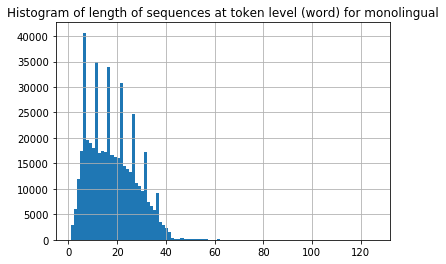

In [84]:
ax = monolingual_stats.hist(bins=100)
ax.set_title("Histogram of length of sequences at token level (word) for monolingual")

In [85]:
bilingual_stats = pd.Series([len(s) for s in train_lang1_en_tokenized])
bilingual_stats.describe(percentiles=[.25, .5, .75, .9, .99])

count    11000.000000
mean        18.684909
std          9.864211
min          1.000000
25%         11.000000
50%         18.000000
75%         26.000000
90%         32.000000
99%         41.000000
max         95.000000
dtype: float64

Text(0.5, 1.0, 'Histogram of length of sequences at token level (word) for bilingual')

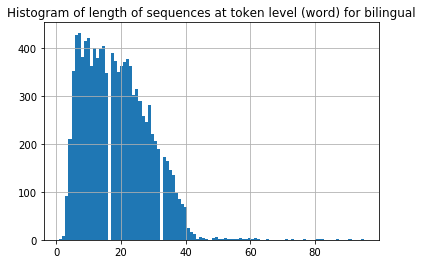

In [86]:
ax = bilingual_stats.hist(bins=100)
ax.set_title("Histogram of length of sequences at token level (word) for bilingual")


Safety check OK: the distribution of sequences seems very similar between both dataset

The actual number of sentences in 492k in the monolingual (not 470k)

## Numericalize English corpora

In [89]:
word_to_token_en = create_vocab(unaligned_en_tokenized)
word_to_token_en = create_vocab(train_lang1_en_tokenized, word_to_token_en)

In [90]:
token_to_word_en = {v:k  for k,v in word_to_token_en.items()}

In [92]:
for key in np.random.choice(list(word_to_token_en.keys()), size=10):
    print(key, word_to_token_en[key])

transparent 5069
write 155
fujita 47987
marcie 56907
advancing 3568
sliders 50352
spendthrift 46855
notably 6856
enrol 54436
isfahan 35237


In [95]:
with open('word_to_token_en.pickle', 'wb') as handle:
    pickle.dump(word_to_token_en, handle, protocol=pickle.HIGHEST_PROTOCOL)
    
with open('token_to_word_en.pickle', 'wb') as handle:
    pickle.dump(token_to_word_en, handle, protocol=pickle.HIGHEST_PROTOCOL)


In [105]:
unaligned_en_numericalized = [[word_to_token_en[w]  for w in s] for s in unaligned_en_tokenized]

In [109]:
" ".join([token_to_word_en[t] for t in np.random.choice(unaligned_en_numericalized)])

'i made my report available in all accessible formats at my own expense'

In [106]:
len(unaligned_en_tokenized), len(unaligned_en_numericalized)

(492443, 492443)

In [110]:
train_lang1_en_numericalized = [[word_to_token_en[w]  for w in s] for s in train_lang1_en_tokenized]

In [111]:
" ".join([token_to_word_en[t] for t in np.random.choice(train_lang1_en_numericalized)])

'this makes it necessary to have proper rules governing transport of this kind'

In [112]:
len(train_lang1_en_tokenized), len(train_lang1_en_numericalized)

(11000, 11000)

In [113]:
with open('train_lang1_en_numericalized.pickle', 'wb') as handle:
    pickle.dump(train_lang1_en_numericalized, handle, protocol=pickle.HIGHEST_PROTOCOL)
    
with open('unaligned_en_numericalized.pickle', 'wb') as handle:
    pickle.dump(unaligned_en_numericalized, handle, protocol=pickle.HIGHEST_PROTOCOL)


In [87]:
# TODO HERE faire la même pour le français et sauver le tout

# Preprocessing French corpora

## Check to see if tokenizer can have preprocess monolingual dataset to look similar to bilangual dataset

In [164]:
unaligned_fr_tokenized = list(my_tokenize(unaligned_fr[:30], tokenizer=tokenizer_fr, 
                               keep_case=True, keep_punctuation=True))
# Required also to extend the vocab
train_lang2_fr_tokenized = list(my_tokenize(train_lang2_fr, tokenizer=tokenizer_fr, 
                                   keep_case=True, keep_punctuation=True, split_sentence=True))

In [165]:
len(train_lang2_fr_tokenized)

11000

In [166]:
doc = tokenizer_fr("l' Union européenne", disable=["parser", "entity", "ner"])
[t for t in doc]

[l, ', Union, européenne]

In [172]:
train_lang2_fr.text[4]

"Le territoire marin de l' Union européenne est plus vaste que son territoire terrestre . On y dénombre 1 200 ports et 90 % de ses exportations sont acheminées par mer ."

In [173]:
train_lang2_fr.text[427]

"A la seconde , consciemment ou pas . A l ’ instant où vous décidez de vous concentrer sur quelque chose vous devez lui donnez un sens , Et quel qu' il soit , ce sens produit de l’ émotion ."

In [174]:
nb_mistake = 0
for i in range(len(train_lang2_fr)):
    if train_lang2_fr.text[i] != " ".join(train_lang2_fr_tokenized[i]).replace(" ’", "’").replace(" ' ", "' ").replace(" '", "'"):
        print(i)
        print(train_lang2_fr.text[i])
        print(" ".join(train_lang2_fr_tokenized[i]).replace(" ’", "’").replace(" ' ", "' ").replace(" '", "'"))
        nb_mistake += 1
        if nb_mistake > 5:
            break

427
A la seconde , consciemment ou pas . A l ’ instant où vous décidez de vous concentrer sur quelque chose vous devez lui donnez un sens , Et quel qu' il soit , ce sens produit de l’ émotion .
A la seconde , consciemment ou pas . A l’ instant où vous décidez de vous concentrer sur quelque chose vous devez lui donnez un sens , Et quel qu' il soit , ce sens produit de l’ émotion .
1247
Je tiens à mettre en garde contre un assouplissement de la norme lorsqu ' il s' agit de juger la situation des droits de l' homme en Afrique où les violations pourraient être considérées comme des incidents inévitables .
Je tiens à mettre en garde contre un assouplissement de la norme lorsqu' il s' agit de juger la situation des droits de l' homme en Afrique où les violations pourraient être considérées comme des incidents inévitables .
1515
Ce corridor , aujourd ' hui , est plus qu' un symbole , une réalité , fragile , mais tangible .
Ce corridor , aujourd' hui , est plus qu' un symbole , une réalité , f

In [176]:
# Below sentences are the ones with a mismatch after tokenizer
mask = train_lang2_fr.text.isin([" ".join(s).replace(" ’", "’").replace(" ' ", "' ").replace(" '", "'") for s in train_lang2_fr_tokenized])
train_lang2_fr[~mask]#[:5]

,text
427,"A la seconde , consciemment ou pas . A l ’ instant où vous décidez de vous concentrer sur quelque chose vous devez lui donnez un sens , Et quel qu' il soit , ce sens produit de l’ émotion ."
1247,Je tiens à mettre en garde contre un assouplissement de la norme lorsqu ' il s' agit de juger la situation des droits de l' homme en Afrique où les violations pourraient être considérées comme des incidents inévitables .
1515,"Ce corridor , aujourd ' hui , est plus qu' un symbole , une réalité , fragile , mais tangible ."
2034,"On pouvait lire ce matin le titre suivant dans un quotidien néerlandais : "" l ' Europe sauve la tartine des laveurs de vitres "" ."
2230,C' est rentable . et c' est très ' maillage ' .
2789,"Ces programmes développent ce que le journaliste américain Edward R. Murrow a qualifié d ’ « ultimes trois pieds » déterminants - communication face à face , avec la crédibilité accrue que crée la réciprocité ."
3893,"Cependant , il nous faut admettre que nous avons jusqu ' à présent été inopérants , puisque ces réseaux se multiplient , et nous avons recueilli récemment des témoignages sur leur action , notamment l' exploitation de femmes originaires d' Albanie et du Kosovo ."
4746,"( L ' Assemblée , debout , applaudit longuement l' orateur )"
6735,"Il y a trois ans , si quelqu ' un s' était levé ici pour annoncer ce qu' il se passe aujourd ' hui , il aurait certainement été traité de fou ."
7248,Vous n’ avez ressenti aucune pitié pour vos victimes ? » C’ étaient des meurtres très ‘ intimes ’ : il a étranglé ses victimes .


In [177]:
pd.Series([" ".join(s).replace(" ’", "’").replace(" ' ", "' ").replace(" '", "'") for s in train_lang2_fr_tokenized])[~mask]


427                                                                                                                                                                                                                                                     A la seconde , consciemment ou pas . A l’ instant où vous décidez de vous concentrer sur quelque chose vous devez lui donnez un sens , Et quel qu' il soit , ce sens produit de l’ émotion .
1247                                                                                                                                                                                                                     Je tiens à mettre en garde contre un assouplissement de la norme lorsqu' il s' agit de juger la situation des droits de l' homme en Afrique où les violations pourraient être considérées comme des incidents inévitables .
1515                                                                                                                          

Tokenizer logic keep the structure (except for quote but not a lot of occurence)

Actually, it fixes some incoherences in the bilingual dataset ("l'" and "l '")

## Tokenize French corpora

In [178]:
unaligned_fr_tokenized = list(my_tokenize(unaligned_fr, tokenizer=tokenizer_fr, 
                               keep_case=True, keep_punctuation=True))
# Required also to extend the vocab
train_lang2_fr_tokenized = list(my_tokenize(train_lang2_fr, tokenizer=tokenizer_fr, 
                                   keep_case=True, keep_punctuation=True, split_sentence=True))

In [180]:
np.random.choice(unaligned_fr_tokenized)

['Il',
 'faudra',
 'juste',
 'voir',
 'de',
 'quelle',
 'manière',
 'on',
 'peut',
 "s'",
 'assurer',
 "qu'",
 'on',
 'a',
 'une',
 'valeur',
 'ajoutée',
 'de',
 "l'",
 'utilisation',
 'du',
 'budget',
 'européen',
 'pour',
 'ce',
 'type',
 'de',
 'programme',
 'tout',
 'en',
 'laissant',
 'la',
 'flexibilité',
 'aux',
 'États',
 'membres',
 'pour',
 'une',
 'bonne',
 'utilisation',
 '.']

## Compare vocab in both English corpura

In [181]:
word_to_token_fr_monolingual = create_vocab(unaligned_fr_tokenized)

word_to_token_fr_bilangual = create_vocab(train_lang2_fr_tokenized)

In [182]:
present_in_bilangual_not_monolingual = { k : word_to_token_fr_bilangual[k] 
                                        for k in 
                                        set(word_to_token_fr_bilangual) - 
                                        set(word_to_token_fr_monolingual) }
print("Unique tokens from bilangual corpus", len(present_in_bilangual_not_monolingual) / len(word_to_token_fr_bilangual))

Unique tokens from bilangual corpus 0.041714756801319045


In [183]:
present_in_monolingual_not_bilangual = { k : word_to_token_fr_monolingual[k] 
                                        for k in 
                                        set(word_to_token_fr_monolingual) - 
                                        set(word_to_token_fr_bilangual) }
print("Unique tokens from monolingual corpus", len(present_in_monolingual_not_bilangual) / len(word_to_token_fr_monolingual))

Unique tokens from monolingual corpus 0.8073583029499503


Safety check OK: 4% only present in bilingual not in monlingual (80% for the reverse)

## Some statistics at token level

In [184]:
monolingual_stats = pd.Series([len(s) for s in unaligned_fr_tokenized])
monolingual_stats.describe(percentiles=[.25, .5, .75, .9, .99])

count    496141.000000
mean         21.697247
std          11.482779
min           1.000000
25%          12.000000
50%          20.000000
75%          30.000000
90%          38.000000
99%          48.000000
max         214.000000
dtype: float64

Text(0.5, 1.0, 'Histogram of length of sequences at token level (word) for monolingual')

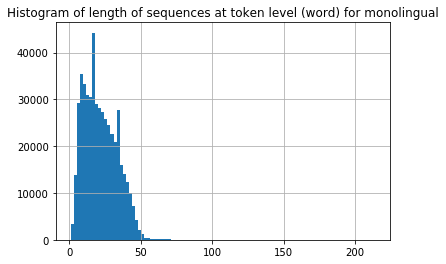

In [185]:
ax = monolingual_stats.hist(bins=100)
ax.set_title("Histogram of length of sequences at token level (word) for monolingual")

In [186]:
bilingual_stats = pd.Series([len(s) for s in train_lang2_fr_tokenized])
bilingual_stats.describe(percentiles=[.25, .5, .75, .9, .99])

count    11000.000000
mean        24.060455
std         12.468354
min          2.000000
25%         14.000000
50%         23.000000
75%         33.000000
90%         41.000000
99%         52.000000
max        121.000000
dtype: float64

Text(0.5, 1.0, 'Histogram of length of sequences at token level (word) for bilingual')

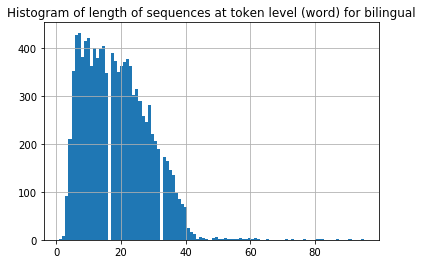

In [86]:
ax = bilingual_stats.hist(bins=100)
ax.set_title("Histogram of length of sequences at token level (word) for bilingual")


Safety check OK: the distribution of sequences seems similar between both dataset. A bit shorter for the monolingual.

The actual number of sentences in 496k in the monolingual (not 470k)

## Numericalize French corpora

In [187]:
word_to_token_fr = create_vocab(unaligned_fr_tokenized)
word_to_token_fr = create_vocab(train_lang2_fr_tokenized, word_to_token_fr)

In [188]:
token_to_word_fr = {v:k  for k,v in word_to_token_fr.items()}

In [189]:
for key in np.random.choice(list(word_to_token_fr.keys()), size=10):
    print(key, word_to_token_fr[key])

appelèrent 52797
priés 25159
Galicien 36707
strates 52837
échouerez 90677
corrida 53044
fret 10106
posant 6877
employé 5595
anti-conformiste 65549


In [190]:
with open('word_to_token_fr.pickle', 'wb') as handle:
    pickle.dump(word_to_token_fr, handle, protocol=pickle.HIGHEST_PROTOCOL)
    
with open('token_to_word_fr.pickle', 'wb') as handle:
    pickle.dump(token_to_word_fr, handle, protocol=pickle.HIGHEST_PROTOCOL)


In [191]:
unaligned_fr_numericalized = [[word_to_token_fr[w]  for w in s] for s in unaligned_fr_tokenized]

In [192]:
" ".join([token_to_word_fr[t] for t in np.random.choice(unaligned_fr_numericalized)])

"Je crois que les outils qui ont fonctionné dans ces 42 cas pilotes peuvent être consolidés dans des processus standard dans un environnement professionnel , et accessible sur le web , via des centres d' appels ou dans des bureaux franchisés , à coût fixe , afin de servir quiconque serait confronté à une demande de pots de vin ."

In [194]:
len(unaligned_fr_tokenized), len(unaligned_fr_numericalized)

(496141, 496141)

In [195]:
train_lang2_fr_numericalized = [[word_to_token_fr[w]  for w in s] for s in train_lang2_fr_tokenized]

In [196]:
" ".join([token_to_word_fr[t] for t in np.random.choice(train_lang2_fr_numericalized)])

'La même idée peut maintenant être développée .'

In [197]:
len(train_lang2_fr_tokenized), len(train_lang2_fr_numericalized)

(11000, 11000)

In [198]:
with open('train_lang2_fr_numericalized.pickle', 'wb') as handle:
    pickle.dump(train_lang2_fr_numericalized, handle, protocol=pickle.HIGHEST_PROTOCOL)
    
with open('unaligned_fr_numericalized.pickle', 'wb') as handle:
    pickle.dump(unaligned_fr_numericalized, handle, protocol=pickle.HIGHEST_PROTOCOL)


# Conclusion 

English monolingual
- Using sentencizer increases from 470k to 492k sentences
- Must be adapted to look like English bilangual (remove case and punctuation)
- Lot of new tokens
- Stats at token level similar to bilingual
- Can be in memory

English bilingual
- No punctuation and no case
- Max sequences at character level: 512 (possibility of character level production)
- Can be in memory

French monolingual
- Using sentencizer increases from 470k to 496k sentences
- French monolingual don't need special preprocessing
- Lot of new tokens
- Can be in memory


French bilingual
- Punctuation and Case
- Some inconsistences ("l'" and "l '") but can be fixed with tokenizer
- Max sequences at character level: 562 (possibility of character level production)
- Can be in memory


Spacy tokenizer
- Keep the structure between monolingual and bilingual
- Quite fast (30min for 1 monolingual, <1min for 1 bilingual)


Outputs
- 2 files for English corpora, and 1 file for their vocab (1 extra file for the reverse dictionary)
- 2 files for French corpora, and 1 file for their vocab (1 extra file for the reverse dictionary)

Possible improvements
- Generate character level dataset
- Use BPE dataset
- Parallelize the tokenizer (currently single thread)